In [13]:
from PIL import Image
im = Image.open("New/1/00009_930831_fa_a.ppm.bz2.ppm")
# 00002_930831_fa.ppm
# 00002_930831_fb.ppm
# 00002_930831_hl.ppm
# 00002_930831_hr.ppm
# 00002_930831_pr.ppm
# 00002_931230_fa.ppm
im.show()
im.thumbnail((224, 224), Image.ANTIALIAS)
im.show()

In [ ]:
import cv2
import os
import pickle
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

headshots_folder_name = "C:/Users/LiuCh/ml_project/2"

# dimension of images
image_width = 224
image_height = 224

# for detecting faces
facecascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# set the directory containing the images
images_dir = os.path.join(".", headshots_folder_name)
print(images_dir)

current_id = 0
label_ids = {}

# iterates through all the files in each subdirectories
for root, _, files in os.walk(images_dir):
    for file in files:
        # print(file)
        if file.endswith("ppm"):
            # path of the image
            path = os.path.join(root, file)

            # get the label name (name of the person)
        label = os.path.basename(root).replace(" ", ".").lower()

        # add the label (key) and its number (value)
        if not label in label_ids:
            label_ids[label] = current_id
            current_id += 1

        # load the image
        # print(path)
        imgtest = cv2.imread(path, cv2.IMREAD_COLOR)
        image_array = np.array(imgtest, "uint8")

        # get the faces detected in the image
        faces = facecascade.detectMultiScale(imgtest, scaleFactor=1.1, minNeighbors=5)

        # if not exactly 1 face is detected, skip this photo
        if len(faces) != 1:
            print(f'---Photo skipped---\n')
            # remove the original image
            os.remove(path)
            continue

        # save the detected face(s) and associate
        # them with the label
        for (x_, y_, w, h) in faces:

            # draw the face detected
            face_detect = cv2.rectangle(imgtest,
                    (x_, y_),
                    (x_+w, y_+h),
                    (255, 0, 255), 2)
            plt.imshow(face_detect)
            plt.show()

            # resize the detected face to 224x224
            size = (image_width, image_height)

            # detected face region
            roi = image_array[y_: y_ + h, x_: x_ + w]

            # resize the detected head to target size
            resized_image = cv2.resize(roi, size)
            image_array = np.array(resized_image, "uint8")

            # remove the original image
            os.remove(path)

            # replace the image with only the face
            im = Image.fromarray(image_array)
            im.save(path)

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam


In [2]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_generator = \
    train_datagen.flow_from_directory(
'C:/Users/LiuCh/ml_project/traindata19/',
target_size=(224,224),
color_mode='rgb',
batch_size=32,
class_mode='categorical',
shuffle=True)


Found 105 images belonging to 19 classes.


In [3]:
train_generator.class_indices.values()
# dict_values([0, 1, 2])
NO_CLASSES = len(train_generator.class_indices.values())

In [4]:
from keras_vggface.vggface import VGGFace
from tensorflow.keras.layers import Layer, InputSpec

base_model = VGGFace(include_top=True,
    model='vgg16',
    input_shape=(224, 224, 3))
base_model.summary()

print(len(base_model.layers))
# 26 layers in the original VGG-Face


Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

In [5]:
base_model = VGGFace(include_top=False,
model='vgg16',
input_shape=(224, 224, 3))
base_model.summary()
print(len(base_model.layers))
# 19 layers after excluding the last few layers


Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

In [6]:

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)

x = Dense(1024, activation='relu')(x)

x = Dense(512, activation='relu')(x)

# final layer with softmax activation
preds = Dense(NO_CLASSES, activation='softmax')(x)
base_model=Model(inputs=base_model.input,outputs=preds)

base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [7]:
# don't train the first 19 layers - 0..18
for layer in base_model.layers[:19]:
    layer.trainable = False

# train the rest of the layers - 19 onwards
for layer in base_model.layers[19:]:
    layer.trainable = True


In [8]:
base_model.compile(optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])
base_model.fit(train_generator,
  batch_size = 1,
  verbose = 1,
  epochs = 20)


Epoch 1/20
4/4 [==============================] - 18s 4s/step - loss: 2.8366 - accuracy: 0.2190
Epoch 2/20
4/4 [==============================] - 17s 4s/step - loss: 2.4201 - accuracy: 0.2667
Epoch 3/20
4/4 [==============================] - 31s 8s/step - loss: 1.9571 - accuracy: 0.5238
Epoch 4/20
4/4 [==============================] - 50s 15s/step - loss: 1.5669 - accuracy: 0.6000
Epoch 5/20
4/4 [==============================] - 33s 8s/step - loss: 1.2638 - accuracy: 0.6857
Epoch 6/20
4/4 [==============================] - 29s 7s/step - loss: 0.9886 - accuracy: 0.7333
Epoch 7/20
4/4 [==============================] - 28s 6s/step - loss: 0.7581 - accuracy: 0.8476
Epoch 8/20
4/4 [==============================] - 28s 7s/step - loss: 0.5472 - accuracy: 0.9048
Epoch 9/20
4/4 [==============================] - 28s 7s/step - loss: 0.3563 - accuracy: 0.9524
Epoch 10/20
4/4 [==============================] - 28s 8s/step - loss: 0.2673 - accuracy: 0.9429
Epoch 11/20
4/4 [=====================

In [9]:
# creates a HDF5 file
base_model.save(
    'transfer_learning_trained' +
    '_face_cnn_model.h5')

In [11]:
# To verify that the model is saved correctly, delete it from memory and load it from disk again

from tensorflow.keras.models import load_model

# deletes the existing model
del base_model

# returns a compiled model identical to the previous one
model = load_model(
    'transfer_learning_trained' +
    '_face_cnn_model.h5')

In [12]:
# Saving the Training Labels
# Using the ImageDataGenerator instance, you can generate a mapping of the index corresponding to each person's name:

import pickle

class_dictionary = train_generator.class_indices
class_dictionary = {
    value:key for key, value in class_dictionary.items()
}
print(class_dictionary)

{0: '1', 1: '10', 2: '12', 3: '13', 4: '14', 5: '15', 6: '16', 7: '17', 8: '18', 9: '19', 10: '2', 11: '20', 12: '3', 13: '4', 14: '5', 15: '6', 16: '7', 17: '8', 18: '9'}


In [13]:
# save the class dictionary to pickle
face_label_filename = 'face-labels.pickle'
with open(face_label_filename, 'wb') as f: pickle.dump(class_dictionary, f)

In [14]:
# Testing the Trained Model

import cv2
import os
import pickle
import numpy as np
import pickle

from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras_vggface import utils

# dimension of images
image_width = 224
image_height = 224

# load the training labels
face_label_filename = 'face-labels.pickle'
with open(face_label_filename, "rb") as \
    f: class_dictionary = pickle.load(f)

class_list = [value for _, value in class_dictionary.items()]
print(class_list)


['1', '10', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9']


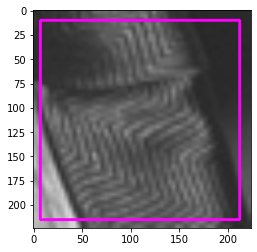

1/1 [==============================] - 0s 487ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
18
Predicted face: 9



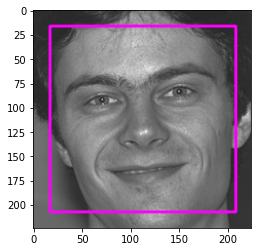

1/1 [==============================] - 0s 266ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
10
Predicted face: 2



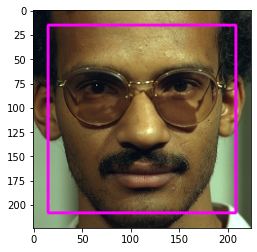

1/1 [==============================] - 0s 231ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
12
Predicted face: 3



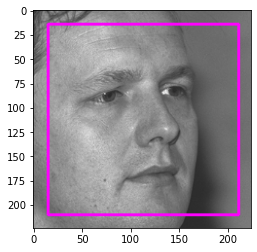

1/1 [==============================] - 0s 226ms/step
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
4
Predicted face: 14



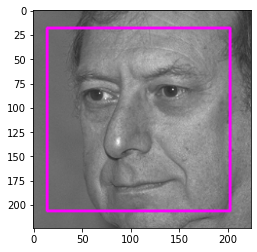

1/1 [==============================] - 0s 234ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
14
Predicted face: 5



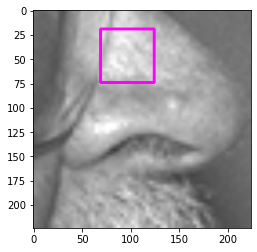

1/1 [==============================] - 0s 262ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
9
Predicted face: 19

---We need exactly 1 face; photo skipped---



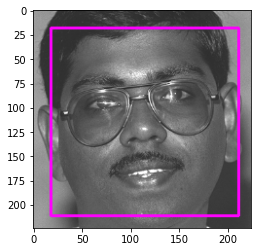

1/1 [==============================] - 0s 208ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
17
Predicted face: 8



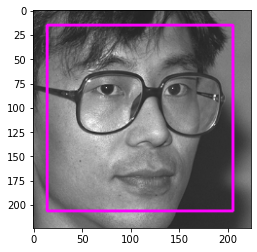

1/1 [==============================] - 0s 210ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
18
Predicted face: 9



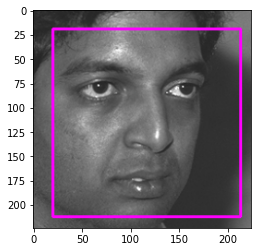

1/1 [==============================] - 0s 197ms/step
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
1
Predicted face: 10



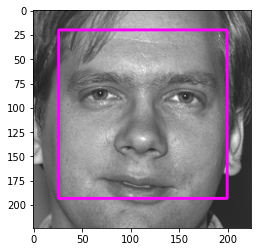

1/1 [==============================] - 0s 196ms/step
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
2
Predicted face: 12



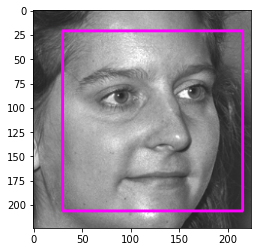

1/1 [==============================] - 0s 206ms/step
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 1.3407982e-25 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]
3
Predicted face: 13



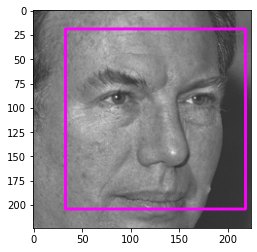

1/1 [==============================] - 0s 198ms/step
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
4
Predicted face: 14



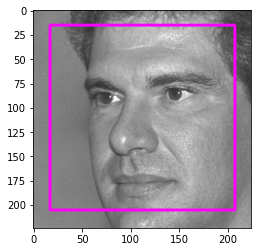

1/1 [==============================] - 0s 229ms/step
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
5
Predicted face: 15



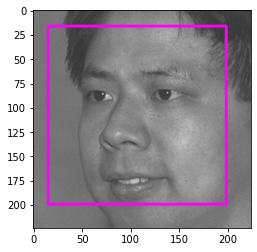

1/1 [==============================] - 0s 255ms/step
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
6
Predicted face: 16



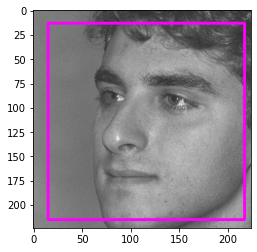

1/1 [==============================] - 0s 263ms/step
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
7
Predicted face: 17



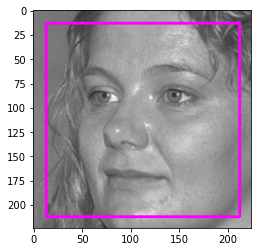

1/1 [==============================] - 0s 191ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
8
Predicted face: 18



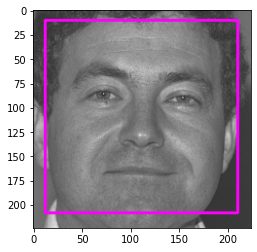

1/1 [==============================] - 0s 197ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
9
Predicted face: 19

---We need exactly 1 face; photo skipped---



In [21]:
from tensorflow.keras.utils import img_to_array
# for detecting faces
facecascade = cv2.CascadeClassifier(
    'haarcascade_frontalface_default.xml')

for i in [1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20]:
    test_image_filename = f'./testdata/{i}.ppm'

    # load the image
    imgtest = cv2.imread(test_image_filename, cv2.IMREAD_COLOR)
    image_array = np.array(imgtest, "uint8")

    # get the faces detected in the image
    faces = facecascade.detectMultiScale(imgtest, 
        scaleFactor=1.1, minNeighbors=5)

    # if not exactly 1 face is detected, skip this photo
    if len(faces) != 1: 
        print(f'---We need exactly 1 face; photo skipped---')
        print()
        continue

    for (x_, y_, w, h) in faces:
        # draw the face detected
        face_detect = cv2.rectangle(
            imgtest, (x_, y_), (x_+w, y_+h), (255, 0, 255), 2)
        plt.imshow(face_detect)
        plt.show()

        # resize the detected face to 224x224
        size = (image_width, image_height)
        roi = image_array[y_: y_ + h, x_: x_ + w]
        resized_image = cv2.resize(roi, size)

        # prepare the image for prediction
        x = img_to_array(resized_image)
        x = np.expand_dims(x, axis=0)
        x = utils.preprocess_input(x, version=1)

        # making prediction
        predicted_prob = model.predict(x)
        print(predicted_prob)
        print(predicted_prob[0].argmax())
        print("Predicted face: " + class_list[predicted_prob[0].argmax()])
        print("============================\n")